In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
from torch.nn import functional as F
import scipy.stats
import sklearn.datasets

import sys
sys.path.append("../")
import curvvae_lib.train.predictive_passthrough_trainer as ppttrainer
import curvvae_lib.architecture.passthrough_vae as ptvae
import curvvae_lib.architecture.save_model as sm
import curvvae_lib.architecture.load_model as lm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-eqjc2_gc because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Dataset

In [2]:
foodname = "banana"
foldername = f"fork_trajectory_{foodname}"
savefilename = f"{foodname}_clean_pickups"

In [3]:
train = []
training_ts = np.linspace(0,1,64)
attempt = 1
while True:
    try:
        raw_vals = np.load(f"{savefilename}/pickup_attempt{attempt}.npy")
        train.append(raw_vals.T.flatten())
    except:
        print(f"We found {attempt-1} pickup attempts")
        break
    attempt += 1

train = np.array(train).reshape(-1,7,64)
all_points = train[:,:,:]

time_shape = list(all_points.shape)
time_shape[1] = 1
# why be smart when you can be dumb
t = np.ones(time_shape)
for i in range(time_shape[2]):
    t[:,:,i] = t[:,:,i] * i / (time_shape[2] + 0.0)

all_points = np.concatenate((t, all_points), axis=1)
all_points = all_points.transpose(0,2,1)

start_points = all_points[:,0,1:]
# See http://localhost:8889/notebooks/scratchwork/2021-09-17%20Rotation%20Scaling.ipynb
# for why we want quaternion values to be multiplied by 0.16 when position values are in meters 
# (if the relevant distance scale of the fork is 0.08 meters, ie: 8cm).
mean = np.mean(start_points, axis=0)
variance = np.var(start_points, axis=0)
position_std = np.sqrt(np.max(variance))
print("std of: ", position_std)
position_scaling = 1/position_std
rotation_scaling = 0.16 * position_scaling

start_points = start_points - mean
poss = position_scaling
rts = rotation_scaling
start_points = (start_points * np.array((poss,poss,poss,rts,rts,rts,rts)))
print("shape before reducing dimension", all_points.shape)
print("dataset variance of:", np.var(start_points,axis=0))

We found 155 pickup attempts
std of:  0.17514298792733465
shape before reducing dimension (155, 64, 8)
dataset variance of: [0.00194911 0.00125788 0.00133692 0.00681216 0.0256     0.00585762
 0.0066191 ]


In [4]:
dataset = start_points
dataset

array([[ 0.04595317, -0.05441428, -0.01690089, ...,  0.05443873,
         0.03846967,  0.04641757],
       [-0.0741912 , -0.01686631, -0.02128294, ..., -0.05807739,
        -0.04147228, -0.07553821],
       [ 0.01013517, -0.02150781, -0.03167534, ...,  0.0575545 ,
         0.0088552 ,  0.04299195],
       ...,
       [-0.01898356,  0.01555381, -0.01404171, ..., -0.08089616,
        -0.04851974,  0.05299186],
       [-0.03843893,  0.02241283,  0.00362743, ..., -0.24245387,
        -0.07568732,  0.03212889],
       [ 0.01442239, -0.00144738, -0.00559424, ...,  0.21880809,
         0.10839383,  0.05271387]])

In [5]:
train_indices = np.arange(0,len(dataset),2)
test_indices = [i for i in range(len(dataset)) if i not in train_indices]
train_dataset=dataset[train_indices]
test_dataset=dataset[test_indices]

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,0],train_dataset[:,1],train_dataset[:,2]);
ax.scatter(test_dataset[:,0],test_dataset[:,1],test_dataset[:,2]);

<IPython.core.display.Javascript object>

In [7]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(train_dataset[:,3],train_dataset[:,4],train_dataset[:,5]);
ax.scatter(test_dataset[:,3],test_dataset[:,4],test_dataset[:,5]);

<IPython.core.display.Javascript object>

## 2D VAE Fit to Dataset

In [8]:
def LoadDataBatch(all_points, batchsize, passthroughdim, predictive, device):
    """Sample Pair of Points from Trajectory"""
    # all_points should be of dimension: num_trajectories, numtimesteps, 1+spatialdims
    traj_ids = np.random.choice(all_points.shape[0], batchsize)
    t1_ids = np.random.choice(all_points.shape[1], batchsize)
    if predictive:
        t2_ids = np.random.choice(all_points.shape[1], batchsize)
    else:
        t2_ids = t1_ids
    return (torch.tensor(all_points[traj_ids, t1_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t1_ids,:passthroughdim], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,passthroughdim:], dtype=torch.float).to(device),
            torch.tensor(all_points[traj_ids, t2_ids,:passthroughdim], dtype=torch.float).to(device))

In [9]:
class Loader(object):
    def __init__(self, all_points, batchsize, passthroughdim, epochnumbatches, predictive, device):
        self.all_points = all_points
        self.batchsize = batchsize
        self.passthroughdim = passthroughdim
        self.epochnumbatches = epochnumbatches
        self.predictive = predictive
        self.device = device
        
    def __iter__(self):
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= self.epochnumbatches:
            # https://docs.python.org/3/library/exceptions.html#StopIteration
            raise StopIteration
        self.n += 1
        return LoadDataBatch(self.all_points, self.batchsize, self.passthroughdim, self.predictive, self.device)
    

device = "cpu"
  

In [10]:
dataset_dim = dataset.shape[-1]
def make_vae(latent_dim):
    input_dim = dataset_dim 
    passthrough_dim = 0
    emb_layer_widths = [1000]
    recon_layer_widths = [1000]
    dtype = torch.float
    model = ptvae.FCPassthroughVAE(input_dim, passthrough_dim, latent_dim,
        emb_layer_widths, recon_layer_widths, dtype)
    return model

In [11]:
def error(vae, dataset):
    embeds = vae.encode(torch.tensor(dataset,dtype=torch.float),
                       torch.tensor(np.zeros((len(dataset),0)),dtype=torch.float)
                       )[0].detach().cpu().numpy()
    recons = vae.decode(torch.tensor(embeds,dtype=torch.float),
              torch.tensor(np.zeros((len(embeds),0)),dtype=torch.float))[0].detach().cpu()
    rmse = np.sqrt(np.mean(np.sum(np.square(dataset - recons.numpy()),axis=1)))
    return rmse

In [12]:
# train a CurvVAE model with given beta and gamma and return
# the string name of the saved model
def train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset,device="cpu"):
    vae = make_vae(latent_dim=latentdim).to(device)
    num_epochs = epochs
    epsilon_scale_start = 0.5
    epsilon_scale = epsilon_scale_start
    savedir  = f'{testname}lat{latentdim}_lr{lr}_gamma{gamma}_es{epsilon_scale_start}_beta{beta}_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
    print(savedir)
    train_loader = Loader(train_dataset[:,np.newaxis,:], 256, 0,10,predictive=False, device=device)
    trainer = ppttrainer.PPTVAETrainer(vae, train_loader, beta=beta, device=device,
        log_dir=savedir, lr=lr, annealingBatches=0, record_loss_every=200, loss_func = "gaussian")
    epoch = 0
    traintesterrors = []
    for _ in range(num_epochs*3):
        epoch+=1
        # up num sample points to reduce variance of curvature measure
        embst = trainer.train(second_deriv_regularizer=secreg, curvature_regularizer=gamma, epsilon_scale = epsilon_scale, num_new_samp_points=512)
        is_error = embst[0]
        if is_error:
            raise Exception
        if epoch % 10 == 0:
            traintesterrors.append((epoch,error(vae,train_dataset),error(vae,test_dataset)))
    sm.save_fcpassthrough_vae(vae, savedir)
    print(savedir)
    return savedir,traintesterrors

In [13]:
test_dataset.shape

(77, 7)

In [43]:
testname = "overfitting/testcode"
#all_models=[]
#all_traintesterrors = []
#for beta,gamma in [[0.00001, 0],
#                   [0.0001, 0],
#                   [0.001  , 0],
#                   [0.01  , 0],
#                   [1.0    , 0],
#                   [0.00001, 0.00001],
#                   [0.00001, 0.00002],
#                   [0.00001, 0.00005],
#                   [0.00001, 0.0001 ],
#                   [0.00001, 0.001  ]
#                  ]:
for beta,gamma in[[0.006,0],
                  [0.00001, 0.01],
                  [0.00001, 0.1],
                  [0.00001, 0.00003],
                  [0.00001, 0.00004],
                  [0.00001, 0.002],
                  [0.00001, 0.005]]:
    secreg = 0
    latentdim = 2
    lr = 0.0001
    epochs=600
    savedir,traintesterrors = train_vae_model(beta,gamma,lr,epochs,latentdim,testname,train_dataset,test_dataset)
    all_models.append((beta,gamma,latentdim,lr,savedir))
    all_traintesterrors.append(traintesterrors)

overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta0.006_20220714-203501
overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta0.006_20220714-203501
overfitting/testcodelat2_lr0.0001_gamma0.01_es0.5_beta1e-05_20220714-203723
overfitting/testcodelat2_lr0.0001_gamma0.01_es0.5_beta1e-05_20220714-203723
overfitting/testcodelat2_lr0.0001_gamma0.1_es0.5_beta1e-05_20220714-203944
overfitting/testcodelat2_lr0.0001_gamma0.1_es0.5_beta1e-05_20220714-203944
overfitting/testcodelat2_lr0.0001_gamma3e-05_es0.5_beta1e-05_20220714-204206
overfitting/testcodelat2_lr0.0001_gamma3e-05_es0.5_beta1e-05_20220714-204206
overfitting/testcodelat2_lr0.0001_gamma4e-05_es0.5_beta1e-05_20220714-204431
overfitting/testcodelat2_lr0.0001_gamma4e-05_es0.5_beta1e-05_20220714-204431
overfitting/testcodelat2_lr0.0001_gamma0.002_es0.5_beta1e-05_20220714-204652
overfitting/testcodelat2_lr0.0001_gamma0.002_es0.5_beta1e-05_20220714-204652
overfitting/testcodelat2_lr0.0001_gamma0.005_es0.5_beta1e-05_20220714-204913
overfitting/t

In [37]:
#savedirs = [
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1e-05_20220714-180311",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1e-05_20220714-180335",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1e-05_20220714-180359",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta0.001_20220714-180422",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta0.001_20220714-180447",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta0.001_20220714-180510",
#"overfitting/testcodelat2_lr0.0001_gamma0_es1.0_beta1.0_20220714-180535",
#"overfitting/testcodelat2_lr0.0001_gamma0.001_es1.0_beta1.0_20220714-180558",
#"overfitting/testcodelat2_lr0.0001_gamma1_es1.0_beta1.0_20220714-180621"
#]

In [38]:
all_traintesterrors

[[(10, 0.2248158089765223, 0.23523479525695418),
  (20, 0.22123838477190957, 0.23201077065979897),
  (30, 0.22004695684812647, 0.23062297970853393),
  (40, 0.21864176810861685, 0.22749814971266843),
  (50, 0.20862187605733626, 0.2172913409115143),
  (60, 0.16134595703483506, 0.17417685018559748),
  (70, 0.1313788024460737, 0.1470674877061898),
  (80, 0.12569064340350822, 0.14385114715296188),
  (90, 0.12517532570625975, 0.14598985120584979),
  (100, 0.1234657659324616, 0.14285655812090592),
  (110, 0.12291158545924483, 0.14364777766405634),
  (120, 0.12182702264267758, 0.1441550184315768),
  (130, 0.12144276594574317, 0.1458568044639446),
  (140, 0.12075990500920263, 0.14676768156659686),
  (150, 0.11988117725893511, 0.1459557260554782),
  (160, 0.1192065381458201, 0.14546601013547628),
  (170, 0.1180536493501938, 0.14623550868729057),
  (180, 0.11582804200660535, 0.1450039806777221),
  (190, 0.11110261992682063, 0.1425345324084075),
  (200, 0.10092501486678306, 0.13490342962369434),
 

In [68]:
"(beta,gamma,latentdim,lr)"
["%s_%s_%s_%s" % i[:4] for i in all_models if i[0]==1e-5]
["%s_%s_%s_%s" % i[:4] for i in all_models if i[0]!=1e-5]

['2e-05_0_2_0.0001',
 '5e-05_0_2_0.0001',
 '0.001_0_2_0.0001',
 '1.0_0_2_0.0001',
 '0.01_0_2_0.0001',
 '0.1_0_2_0.0001',
 '0.02_0_2_0.0001',
 '0.005_0_2_0.0001',
 '0.04_0_2_0.0001',
 '0.008_0_2_0.0001',
 '0.006_0_2_0.0001']

In [ ]:
#['1e-05_0_2_0.0001',
# '1e-05_1e-05_2_0.0001',
# '1e-05_2e-05_2_0.0001',
# '1e-05_5e-05_2_0.0001',
# '1e-05_0.0001_2_0.0001',
# '1e-05_0.001_2_0.0001',
# '1e-05_0.01_2_0.0001',
# '1e-05_0.1_2_0.0001',
# '1e-05_3e-05_2_0.0001',
# '1e-05_4e-05_2_0.0001',
# '1e-05_0.002_2_0.0001',
# '1e-05_0.005_2_0.0001']

<IPython.core.display.Javascript object>


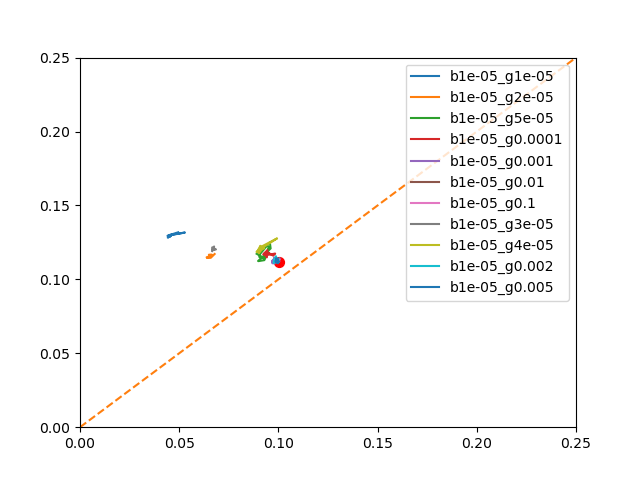

In [62]:
plt.figure()
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    label="b%s_g%s" % (beta,gamma)
    dat = np.array(dat)
    okinds = (dat[:,1] < 0.3) * np.arange(len(dat)) > len(dat)*93/100
    train = dat[okinds,1]
    test = dat[okinds,2]
    if gamma != 0:
        plt.plot(train,test,label=label)
    else:
        pass#plt.plot(train,test,label=label)
plt.xlim(0,0.25)
plt.ylim(0,0.25)
plt.plot([0,0.25],[0,0.25],linestyle="--")
plt.scatter([0.100231085624682], [0.11200086748086831],color="red",s=50)
plt.legend()

<IPython.core.display.Javascript object>


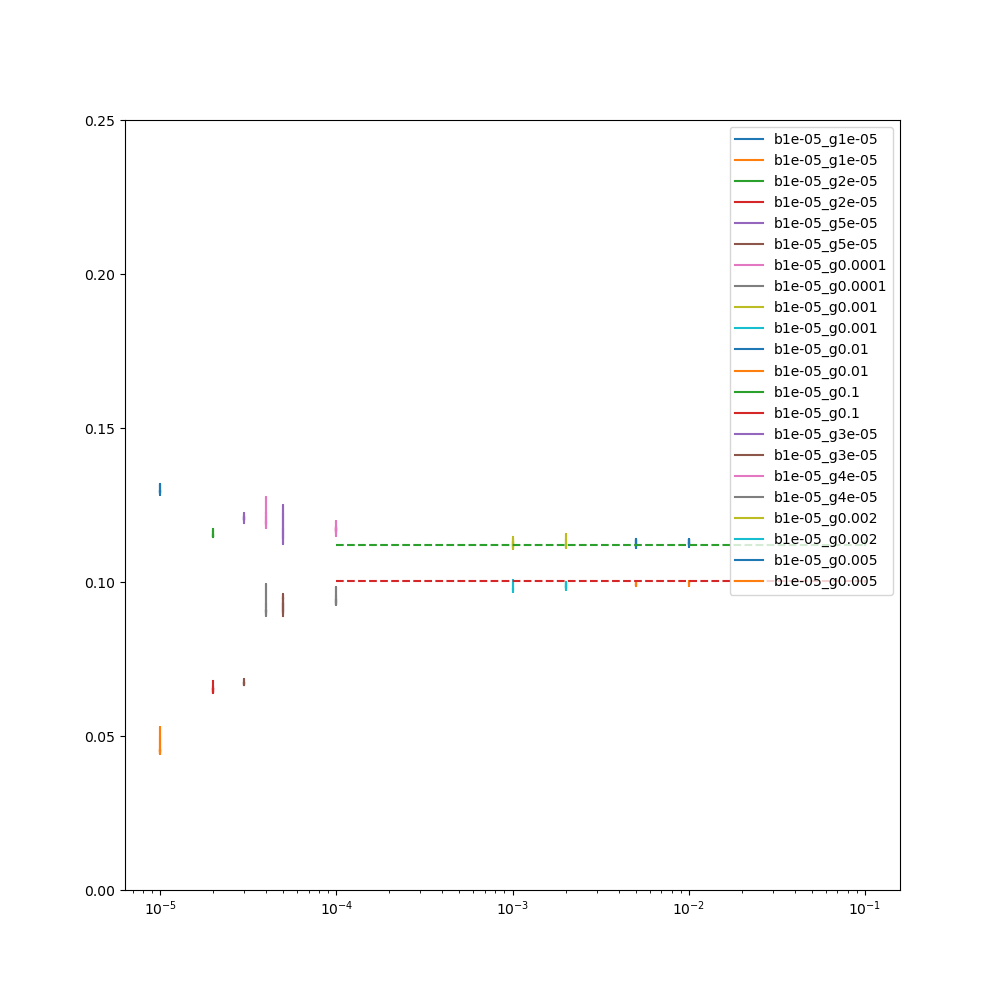

In [57]:
plt.figure(figsize=(10,10))
for i,dat in enumerate(all_traintesterrors):
    (beta,gamma,latentdim,lr,savedir)=all_models[i]
    label="b%s_g%s" % (beta,gamma)
    dat = np.array(dat)
    okinds = (dat[:,1] < 0.3) * np.arange(len(dat)) > len(dat)*93/100
    train = dat[okinds,1]
    test = dat[okinds,2]
    if gamma != 0:
        plt.plot(np.ones_like(test) * gamma,test,label=label)
        plt.plot(np.ones_like(test) * gamma,train,label=label)
    else:
        pass#plt.plot(train,test,label=label)
plt.xscale("log")
plt.ylim(0,0.25)
plt.plot([0.0001,0.1],[0.11200086748086831,0.11200086748086831],linestyle="--")
plt.plot([0.0001,0.1],[0.100231085624682,0.100231085624682],linestyle="--")

plt.legend()

In [18]:

all_models

[(1e-05,
  0,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta1e-05_20220714-193156'),
 (2e-05,
  0,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta2e-05_20220714-193418'),
 (5e-05,
  0,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta5e-05_20220714-193640'),
 (0.001,
  0,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta0.001_20220714-193901'),
 (1.0,
  0,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0_es0.5_beta1.0_20220714-194123'),
 (1e-05,
  1e-05,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma1e-05_es0.5_beta1e-05_20220714-194344'),
 (1e-05,
  2e-05,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma2e-05_es0.5_beta1e-05_20220714-194605'),
 (1e-05,
  5e-05,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma5e-05_es0.5_beta1e-05_20220714-194826'),
 (1e-05,
  0.0001,
  2,
  0.0001,
  'overfitting/testcodelat2_lr0.0001_gamma0.0001_es0.5_beta1e-05_20220714-195046')

In [19]:
testerrors = []
trainerrors = []
for (beta,gamma,latentdim,lr,savedir) in all_models:#savedir in savedirs:#
    testerror = error(savedir, test_dataset)
    testerrors.append(testerror)
    trainerror = error(savedir,train_dataset)
    trainerrors.append(trainerror)
trainerrors=np.array(trainerrors)
testerrors=np.array(testerrors)

TypeError: encode() argument 1 must be str, not Tensor

In [ ]:
plt.figure()
plt.scatter(trainerrors,testerrors)